# Link Analysis

# Table of Content

- [Setup](#setup)
- [Hits](#hits)
- [PageRank](#pagerank)
- [SimRank](#simrank)
- [Result Analysis and Discussion](#result)
- [Computation Performance Analysis](#performance)

---
# <a name='setup'></a> Setup

In [13]:
%matplotlib inline
%load_ext memory_profiler

ImportError: No module named 'memory_profiler'

In [3]:
from collections import namedtuple
from copy import deepcopy
from pprint import PrettyPrinter

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [4]:
pp = PrettyPrinter(indent=4)

## Load Data

In [5]:
Edge = namedtuple('Edge', ('source', 'dest'))

In [6]:
def load_graph_gen(filename):
    with open(filename, 'r') as input_file:
        for line in input_file:
            source, dest = line.strip().split(',')
            yield Edge(source, dest)

In [7]:
file_name_template = 'dataset/graph_{num}.txt'

graphs = list()
for i in range(1, 7):
    filename = file_name_template.format(num=i)
    graph_gen = load_graph_gen(filename)
    graphs.append(nx.DiGraph(graph_gen))

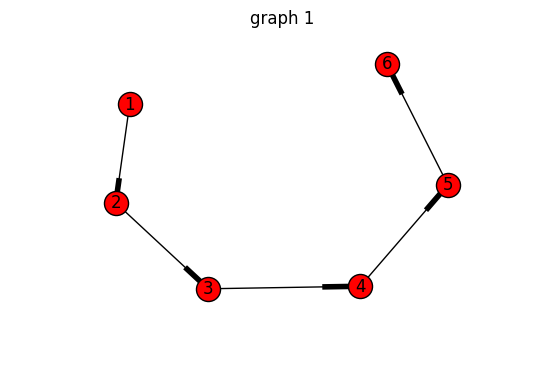

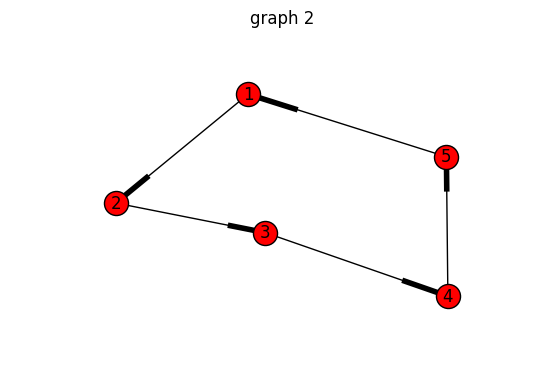

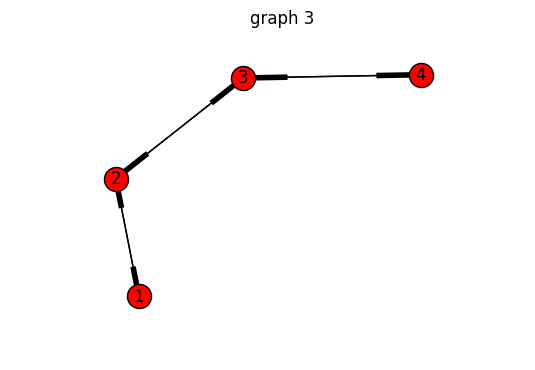

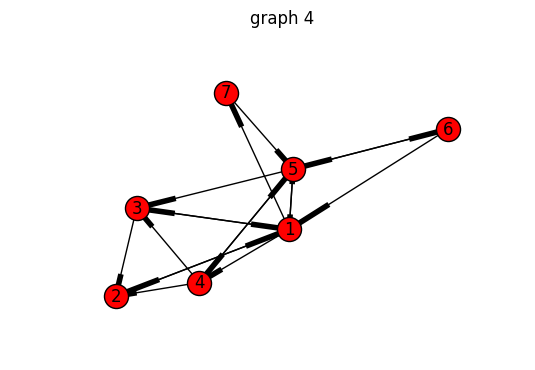

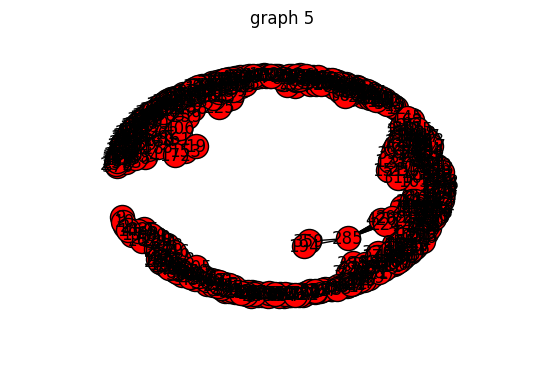

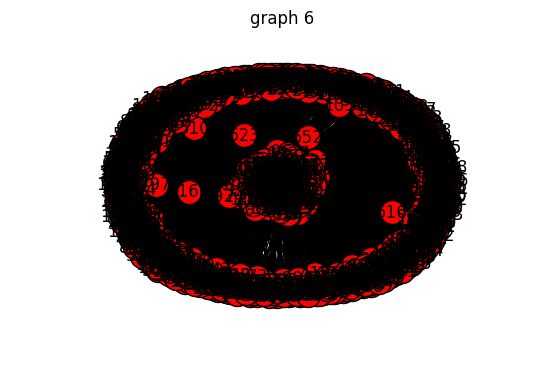

In [8]:
# Visualize  graphs
for index, graph in enumerate(graphs, 1):
    plt.figure(index)
    plt.title('graph {index}'.format(index=index))
    nx.draw(graph, arrows=True, with_labels=True)

In [50]:
G2 = nx.DiGraph()
G2.add_edges_from([(1,3),(2,3),(3,4),(4,1)])

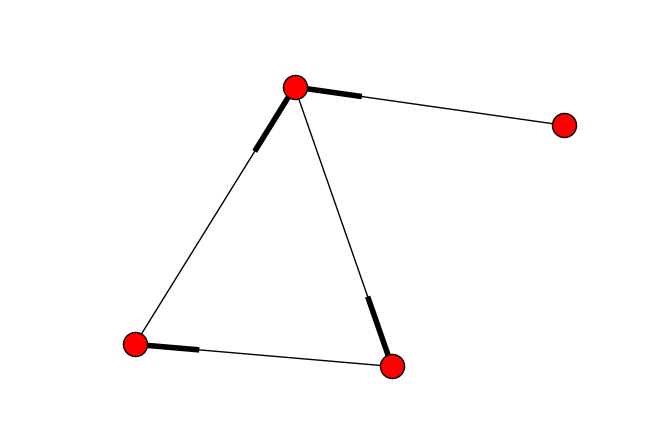

In [51]:
nx.draw(G2)
plt.show()

---
# <a name='hits'></a> Hits

In [9]:
h, a = nx.hits(G1)
print(h)
print(a)

{'2': 0.2, '5': 0.2, '3': 0.2, '4': 0.2, '1': 0.2, '6': 0.0}
{'2': 0.2, '5': 0.2, '3': 0.2, '4': 0.2, '1': 0.0, '6': 0.2}


## self implement of HITS

In [41]:
def initGraph(G):
    for node in G:
        G.add_node(node, authority=1)
        G.add_node(node, hub=1)
    return G

In [42]:
def normalized(G, h, a):
    totalH, totalA, t = 0, 0, 0
    for node in G:
        totalH += h[node]
        totalA += a[node]
    for node in G:
        t += h[node] / totalH - G.node[node]['hub']
        G.node[node]['hub'] = h[node] / totalH
        G.node[node]['authority'] = a[node] / totalA
    return G,t

In [43]:
def authorityHub(G, h, a):
    for node in G:
        h[node], a[node] = 0,0
        for ch in G.successors(node):
            h[node] += G.node[ch]['authority']
        for pa in G.predecessors(node):
            a[node] += G.node[pa]['hub']
    G,t = normalized(G,h,a)
    return G,h,a,t

In [44]:
def HITS(G, max_iter=100, tol=1e-08, nstart=None, normalized=True):
    h, a = {}, {}
    initGraph(G)
    it, t = 0, 1
    while it < max_iter and t > tol:
        G,h,a,t = authorityHub(G,h,a)
        it += 1
    for node in G:
        h[node] = G.node[node]['hub']
        a[node] = G.node[node]['authority']        
    return h,a

In [55]:
G2.successors(1) # = G2.neighbors(1)

[3]

In [54]:
G2.predecessors(3)

[1, 2]

In [56]:
G2.nodes(data=True)

[(1, {}), (2, {}), (3, {}), (4, {})]

In [27]:
def normal(m):
    total = np.sum(m)
    return m/total

In [28]:
def compare(m1, m2):
    result = np.sum(m1) - np.sum(m2)
    return abs(result)

In [29]:
def hits(G, max_iter=100, tol=1e-08, nstart=None, normalized=True):
    k = G.number_of_nodes()
    nodeDict, Hub, Auth = {}, {}, {}
    i, it = 0, 0
    for node in G:
        nodeDict[node] = i
        i += 1
        
    A = np.zeros((k, k))
    for node in G:    
        for n in G.neighbors(node):
            A[nodeDict[node]][nodeDict[n]] = 1
    A.shape=(k,k)  
    AT = np.transpose(A)
    
    h0 = np.ones((k,1))
    a0 = np.ones((k,1))    
    
    pre_h = normal(A.dot(a0))
    pre_a = normal(AT.dot(h0))
    
    h = normal(A.dot(pre_a))
    a = normal(AT.dot(pre_h))

    while it <= max_iter and (compare(h, pre_h) + compare(a, pre_a)) > tol:
        pre_h, pre_a = h, a
        h = normal(A.dot(pre_a))
        a = normal(AT.dot(pre_h))
        it += 1
    
    for key in nodeDict.keys():
        Hub[key] = h[nodeDict[key]][0]
        Auth[key] = a[nodeDict[key]][0]
        
    return Hub, Auth

In [58]:
h2, a2 = hits(G2)
print(h2)
print(a2)

{1: 0.33333333333333331, 2: 0.33333333333333331, 3: 0.16666666666666666, 4: 0.16666666666666666}
{1: 0.25, 2: 0.0, 3: 0.5, 4: 0.25}


In [59]:
h3, a3 = HITS(G2)
print(h3)
print(a3)

{1: 0.25, 2: 0.25, 3: 0.25, 4: 0.25}
{1: 0.25, 2: 0.0, 3: 0.5, 4: 0.25}


In [33]:
h, a = nx.hits(G2)
print(h)
print(a)

{1: 0.49999999813735485, 2: 0.49999999813735485, 3: 1.8626451422920631e-09, 4: 1.8626451422920631e-09}
{1: 3.7252902707063384e-09, 2: 0.0, 3: 0.9999999925494194, 4: 3.7252902707063384e-09}


In [18]:
nx.hits(graphs[0])

({'1': 0.2, '2': 0.2, '3': 0.2, '4': 0.2, '5': 0.2, '6': 0.0},
 {'1': 0.0, '2': 0.2, '3': 0.2, '4': 0.2, '5': 0.2, '6': 0.2})

In [38]:
hits(graphs[0])

({'1': 0.20000000000000001,
  '2': 0.20000000000000001,
  '3': 0.20000000000000001,
  '4': 0.20000000000000001,
  '5': 0.20000000000000001,
  '6': 0.0},
 {'1': 0.0,
  '2': 0.20000000000000001,
  '3': 0.20000000000000001,
  '4': 0.20000000000000001,
  '5': 0.20000000000000001,
  '6': 0.20000000000000001})

In [37]:
nx.hits(graphs[1])

({'1': 0.2, '2': 0.2, '3': 0.2, '4': 0.2, '5': 0.2},
 {'1': 0.2, '2': 0.2, '3': 0.2, '4': 0.2, '5': 0.2})

In [36]:
hits(graphs[1])

({'1': 0.20000000000000001,
  '2': 0.20000000000000001,
  '3': 0.20000000000000001,
  '4': 0.20000000000000001,
  '5': 0.20000000000000001},
 {'1': 0.20000000000000001,
  '2': 0.20000000000000001,
  '3': 0.20000000000000001,
  '4': 0.20000000000000001,
  '5': 0.20000000000000001})

In [21]:
nx.hits(graphs[2])

({'1': 0.1909830056647784,
  '2': 0.3090169943352216,
  '3': 0.3090169943352216,
  '4': 0.1909830056647784},
 {'1': 0.190983005521049,
  '2': 0.309016994478951,
  '3': 0.309016994478951,
  '4': 0.190983005521049})

In [35]:
hits(graphs[2])

({'1': 0.20000000000000001,
  '2': 0.30000000000000004,
  '3': 0.30000000000000004,
  '4': 0.20000000000000001},
 {'1': 0.20000000000000001,
  '2': 0.30000000000000004,
  '3': 0.30000000000000004,
  '4': 0.20000000000000001})

In [22]:
nx.hits(graphs[3])

({'1': 0.27545317656543444,
  '2': 0.04776230637693576,
  '3': 0.10868323971440082,
  '4': 0.1986595564890898,
  '5': 0.18373459934253683,
  '6': 0.11673471394426904,
  '7': 0.06897240756733328},
 {'1': 0.13948389308544967,
  '2': 0.1779120314091907,
  '3': 0.20082320536937326,
  '4': 0.1401777533243232,
  '5': 0.20142536348733986,
  '6': 0.056089261885683465,
  '7': 0.08408849143863971})

In [34]:
hits(graphs[3])

({'1': 0.23214285714285712,
  '2': 0.071428571428571425,
  '3': 0.12499999999999999,
  '4': 0.17857142857142855,
  '5': 0.17857142857142858,
  '6': 0.14285714285714285,
  '7': 0.071428571428571425},
 {'1': 0.14999999999999999,
  '2': 0.16666666666666669,
  '3': 0.20000000000000001,
  '4': 0.15000000000000002,
  '5': 0.18333333333333338,
  '6': 0.066666666666666666,
  '7': 0.083333333333333343})

In [23]:
nx.hits(graphs[4])

({'1': 1.0324628273669701e-19,
  '10': 0.0,
  '100': 0.0,
  '101': 0.0,
  '102': 0.0,
  '103': 0.015029664084517766,
  '104': 0.0,
  '105': 0.0,
  '106': 1.0117920165556644e-20,
  '107': 0.0,
  '108': 0.0,
  '109': 2.740296779057303e-13,
  '11': 9.257103567698097e-20,
  '110': 0.0,
  '111': 0.0,
  '112': 0.0,
  '113': 8.038356894932676e-21,
  '114': 0.0,
  '115': 0.02543914279289668,
  '116': 0.0,
  '117': 0.0,
  '118': 0.0,
  '119': 5.489633966153882e-19,
  '12': 1.447492018258285e-11,
  '120': 0.0,
  '121': 0.0,
  '122': 0.0,
  '123': 0.0,
  '124': 4.991317017051914e-40,
  '125': 0.0,
  '126': 0.0,
  '127': 0.0,
  '128': 0.0,
  '129': 0.0,
  '13': 4.991317017051914e-40,
  '130': 0.013842952127041395,
  '131': 1.3720027745412005e-28,
  '132': 0.0,
  '133': 0.0,
  '134': 0.02128742670358412,
  '135': 0.0,
  '136': 0.0,
  '137': 0.0,
  '138': 0.0,
  '139': 0.0,
  '14': 0.0,
  '140': 0.0,
  '141': 0.014359677890185366,
  '142': 0.0,
  '143': 4.991317017051914e-40,
  '144': 0.0,
  '145': 

In [39]:
hits(graphs[4])

({'1': 0.0015337423312883436,
  '10': 0.0,
  '100': 0.0,
  '101': 0.0,
  '102': 0.0,
  '103': 0.013081919884518223,
  '104': 0.0,
  '105': 0.0,
  '106': 0.0019848430169613859,
  '107': 0.0,
  '108': 0.0,
  '109': 0.0027066041140382533,
  '11': 0.0010826416456153015,
  '110': 0.0,
  '111': 0.0,
  '112': 0.0,
  '113': 0.00027066041140382533,
  '114': 0.0,
  '115': 0.019667989895344639,
  '116': 0.0,
  '117': 0.0,
  '118': 0.0,
  '119': 0.0026163839769036447,
  '12': 0.0061349693251533744,
  '120': 0.0,
  '121': 0.0,
  '122': 0.0,
  '123': 0.0,
  '124': 0.00018044027426921688,
  '125': 0.0,
  '126': 0.0,
  '127': 0.0,
  '128': 0.0,
  '129': 0.0,
  '13': 0.00018044027426921688,
  '130': 0.01154817755322988,
  '131': 0.0007217610970768675,
  '132': 0.0,
  '133': 0.0,
  '134': 0.01723204619271021,
  '135': 0.0,
  '136': 0.0,
  '137': 0.0,
  '138': 0.0,
  '139': 0.0,
  '14': 0.0,
  '140': 0.0,
  '141': 0.012269938650306749,
  '142': 0.0,
  '143': 0.00018044027426921688,
  '144': 0.0,
  '145':

In [25]:
#nx.hits(graphs[5])

In [40]:
hits(graphs[5])

({'581': 0.0065402826139022456,
  '726': 0.0,
  '1196': 0.0,
  '1189': 0.0,
  '414': 0.0,
  '146': 0.0,
  '1039': 0.0,
  '121': 0.0,
  '138': 0.0,
  '1143': 0.0070192892278781831,
  '48': 0.0,
  '638': 0.0029845796716962357,
  '954': 0.0,
  '150': 0.0,
  '51': 0.0,
  '236': 0.0,
  '42': 0.0,
  '824': 0.0,
  '341': 0.0,
  '1038': 0.0,
  '703': 0.0,
  '574': 0.0,
  '521': 8.2904990880450992e-05,
  '670': 0.0,
  '1076': 0.0,
  '467': 0.0,
  '935': 0.0,
  '897': 0.0075443541701210393,
  '39': 0.0,
  '984': 0.0,
  '1135': 0.0,
  '298': 0.0,
  '765': 0.0077285874831887081,
  '632': 0.0,
  '288': 0.0,
  '717': 0.0,
  '180': 0.0071021942187586336,
  '151': 0.0,
  '454': 0.0,
  '547': 0.0,
  '568': 0.0,
  '988': 0.0,
  '1116': 0.0,
  '281': 0.0,
  '494': 0.0,
  '1057': 0.0,
  '1026': 0.00078299158053759263,
  '466': 0.0,
  '1117': 0.0,
  '886': 0.0,
  '390': 0.0,
  '931': 0.00751671917316089,
  '645': 0.0015844064923819523,
  '174': 0.0,
  '715': 0.0,
  '1193': 0.0,
  '1011': 0.0,
  '383': 0.0,

In [19]:
for index, graph in enumerate(graphs, 1):
    print('\nGraph {}'.format(index))
    #pp.pprint(nx.hits(graph))


Graph 1

Graph 2

Graph 3

Graph 4

Graph 5

Graph 6


---
# <a name='pagerank'></a> Page Rank

In [8]:
def pagerank(graph, *, alpha=0.85, episilon=1e-06):
    node_num = graph.number_of_nodes()
    adj_matrix = np.array(nx.to_numpy_matrix(graph))
    out_degs = np.sum(adj_matrix, axis=1)
    damping_factor = 1 - alpha
    
    # Nodes with no outgoing edges
    dangle_nodes = [
        index
        for index, o_deg in enumerate(graph.out_degree().values())
        if not o_deg
    ]
    
    # Page Ranks
    prs = np.array([1/node_num for _ in range(node_num)])
    # Page Ranks in previous iteration
    pre_prs = np.array([0 for _ in range(node_num)])
    
    delta = np.sum(np.abs(prs - pre_prs))
    while delta > episilon:
        pre_prs = deepcopy(prs)
        
        # Page Rank values each node can contribute in each edge
        pr_quotas = np.array(
            [pr/deg if deg else 0 for pr, deg in zip(pre_prs, out_degs)]
        )
        dangle_sum = np.sum([pre_prs[dangle_node]/node_num
                             for dangle_node in dangle_nodes])

        prs = (
            damping_factor / node_num +
            alpha *
            (
                adj_matrix.transpose().dot(pr_quotas[:, np.newaxis]) +
                dangle_sum
            )
        ).flatten()
        
        # Normalize
        prs /= np.sum(prs)
        delta = np.sum(np.abs(prs - pre_prs))
        
    # Mapping node name to its page rank
    prs_mappping = {node: pr for node, pr in zip(graph.nodes(), prs)}
    return prs_mappping

### Reference 
[PageRank Lecture Note](http://www.ccs.northeastern.edu/home/daikeshi/notes/PageRank.pdf)

---
# <a name='simrank'></a> SimRank

In [9]:
np.seterr(divide='ignore', invalid='ignore')

def simrank(graph, *, C=0.8, epsilon=1e-06):
    node_num = graph.number_of_nodes()
    adj_matrix = np.array(nx.to_numpy_matrix(graph))
    adj_matrix /= np.sum(adj_matrix, axis=0)
    adj_matrix = np.nan_to_num(adj_matrix)
    
    pre_sim = np.zeros(node_num)
    sim = np.eye(node_num)
    delta = np.sum(np.abs(sim - pre_sim))
    while delta > epsilon:
        pre_sim = deepcopy(sim)
        sim = C * adj_matrix.transpose().dot(pre_sim).dot(adj_matrix)
        for i in range(node_num):
            sim[i, i] = 1
        delta = np.sum(np.abs(sim - pre_sim))
    return sim

---

# <a name='result'></a> Result Analysis and Discussion

## Hits

## Page Rank

In [10]:
for index, graph in enumerate(graphs, 1):
    print('\nGraph {}'.format(index))
    pp.pprint(pagerank(graph))


Graph 1
{   '1': 0.060716150359376504,
    '2': 0.1123249278306801,
    '3': 0.15619235710247792,
    '4': 0.1934794507762447,
    '5': 0.22517347758916137,
    '6': 0.25211363634205952}

Graph 2
{   '1': 0.20000000000000001,
    '2': 0.20000000000000001,
    '3': 0.20000000000000001,
    '4': 0.20000000000000001,
    '5': 0.20000000000000001}

Graph 3
{   '1': 0.17543856058862933,
    '2': 0.32456143941137072,
    '3': 0.32456143941137072,
    '4': 0.17543856058862933}

Graph 4
{   '1': 0.2802878551778531,
    '2': 0.15876446265602656,
    '3': 0.13888181220259527,
    '4': 0.10821960072742001,
    '5': 0.18419809708011373,
    '6': 0.060570694570464538,
    '7': 0.069077477585526917}

Graph 5
{   '1': 0.0016219554229487472,
    '10': 0.0019564189877011311,
    '100': 0.0017232887848194483,
    '101': 0.0016785662685149874,
    '102': 0.0016803290881002638,
    '103': 0.0017137749250352994,
    '104': 0.0099378200191001815,
    '105': 0.0026171389802050991,
    '106': 0.0019656333783

## Sim Rank

In [11]:
for index, graph in enumerate(graphs, 1):
    print('\nGraph {}'.format(index))
    pp.pprint(simrank(graph))


Graph 1
array([[ 1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.]])

Graph 2
array([[ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  1.]])

Graph 3
array([[ 1.        ,  0.        ,  0.66666655,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.66666655],
       [ 0.66666655,  0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.66666655,  0.        ,  1.        ]])

Graph 4
array([[ 1.        ,  0.3426946 ,  0.53506349,  0.36974703,  0.53506349,
         0.44956621,  0.35373453],
       [ 0.3426946 ,  1.        ,  0.27314849,  0.41218164,  0.4122407 ,
         0.39005383,  0.33765876],
       [ 0.53506349,  0.27314849,  1.        ,  0.2854419 ,  0.27012699,
         0.44809422,  0.

# <a name='performance'></a> Computation Performance Analysis

## Time

### Hits

### Page Rank

In [12]:
%%time

for graph in graphs:
    pagerank(graph)

CPU times: user 62.7 ms, sys: 13.2 ms, total: 75.9 ms
Wall time: 67.5 ms


In [13]:
%%time

for graph in graphs:
    nx.pagerank(graph, alpha=0.85)

CPU times: user 77.5 ms, sys: 2.92 ms, total: 80.4 ms
Wall time: 81.7 ms


### SimRank

In [14]:
%%time

for graph in graphs:
    simrank(graph)

CPU times: user 48.3 s, sys: 1.93 s, total: 50.2 s
Wall time: 20 s


## Memory

### Hits

### Page Rank

In [16]:
%%memit

for graph in graphs:
    pagerank(graph)

peak memory: 136.71 MiB, increment: 23.95 MiB


In [17]:
%%memit

for graph in graphs:
    nx.pagerank(graph, alpha=0.85)

peak memory: 137.86 MiB, increment: 1.35 MiB


###  SimRank

In [18]:
%%memit

for graph in graphs:
    simrank(graph)

peak memory: 177.29 MiB, increment: 39.43 MiB
